In [1]:
from z3 import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
set_param('parallel.enable', True)
set_param('parallel.threads.max', 8)

# Description
A model that keeps track of the cumulative number of bytes (in/out/lost) until timestep $t$. Each propagation delay is divided into a certain number of timesteps

Here, we do not keep track of where every packet is in the buffer, which will hopefully make things run faster since there are fewer variables (but a similar number of constraints to keep track of the buffer).

The loss model is that if the queue is large enough (according to our dynamic threshold), the sender gets to non-deterministically choose to not accept packets. 

# Parameters
* $R$ - propagation delay (in timesteps)
* $T$ - number of timesteps we simulate (assumed divisible by $R$)
* $C$ - the server's transmission rate (in pkts/timestep)
* $Lmax$ - maximum number of packets in the buffer. It needs to be finite so there are fewer constraints for the SMT solver (otherwise constraints will increase that's all)
* $Lmin$ - minimum buffer size that the non-deterministic server can emulate (Lmin >= 1)
* $K$ - the slack parameter
* $CCA$ - The congestion control algorithm we'll use

# Variables
* $out_t$ - Number of packets output from server till time $t$
* $inp_t$ - Number of packets that have been accepted into the buffer till time $t$
* $lthresh_t$ - Threshold on $inp$ above which packets can be dropped
* $lost_t$ - Number of packets lost till time $t$
* $Ku_t, Kl_t$ - upper and lower slack. Can change if the server decides to waste transmission opportunities

* $cwnd_t$ - cwnd at the beginning of timestep $t$
* $rate_t$ - rate (in pkts / RTT) at during timestep $t$ (i.e. in $[t-1, t)$)

* $loss\_detected_t$ - pkt loss detected at time $t$
* $qdel_t$ - queuing delay measured at time $t$

# Constraints
* The maximum queuing delay is $(K + L) / C$. So that's the number of timesteps we need to check
* $\min(inp_t, C t - Kl_t) \le out_t \le C t + Ku_t$ $\Rightarrow \min(inp_t / C, t - Kl_t / C) \le out_t / C \le t + Ku_t / C$

In [2]:
# The parameters
R = 4
T = 10 * R
C = 1.
Lmax = 10
Lmin = 4
D = 3
CCA = 'AIMD'
# Number of dupacks needed for us to detect loss
dupacks = 0

assert(T % R == 0)
# 1 / C should be an integer
assert(int(1. / C) == 1. / C)
C_inv = int(1. / C)

# Prepare the variables
out = [Real("out_%d" % t) for t in range(T)]
inp = [Real("inp_%d" % t) for t in range(T)]
lthresh = [Real("lthresh_%d" % t) for t in range(T)]
lost = [Real("lost_%d" % t) for t in range(T)]
Ku = [Real("Ku_%d" % t) for t in range(T)]
Kl = [Real("Kl_%d" % t) for t in range(T)]

cwnd = [Real("cwnd_%d" % t) for t in range(T)]
rate = [Real("rate_%d" % t) for t in range(T)]

# Amount of data that is known to be lost
lost_detected = [Real("loss_detect_%d" % t) for t in range(T)]
# Data about the last time cwnd was decreased due to loss. Stores the seq num after which cwnd can again decrease due to loss 
last_cwnd_decr = [Real("last_cwnd_decr_%d" % t) for t in range(T)]


#qdel = [Real("qdel_%d" % t) for t in range(T)]

# Write the constraints
s = Solver()
for t in range(1, T):
    # All are monotonic.
    s.add(out[t] >= out[t-1])
    s.add(lost[t] >= lost[t-1])
    s.add(inp[t] >= inp[t-1])

    # Constrain the out[t] / C between the 'black' lines.
    s.add(t - Kl[t] * C_inv <= out[t] * C_inv)
    s.add(t + Ku[t] * C_inv >= out[t] * C_inv)
    
    # Output is bounded above by input.
    s.add(inp[t] >= out[t])

    # Determine if we can waste transmissions
    if t == 1:
        # Disallow waste on the first timestep, since that makes the results a bit different from steady state results
        waste_allowed = False
    else:
        waste_allowed = out[t] >= inp[t-1]
    s.add(Implies(waste_allowed,
                  And(Ku[t] <= Ku[t-1])))
    s.add(Implies(Not(waste_allowed),
                  And(Ku[t] == Ku[t-1],
                      Kl[t] == Kl[t-1])))

    # Constraint between the parallel 'black' lines.
    if t + D < T:
        s.add((t + D) - Kl[(t + D)] * C_inv == t + Ku[t] * C_inv)
    
    # Either restart lthresh or continue it
    restart_lthresh = (out[t] == inp[t])
    s.add(Implies(restart_lthresh,
                  lthresh[t] == out[t] + (Lmin + 1)))
    
    s.add(Implies(Not(restart_lthresh), lthresh[t] == lthresh[t-1] + C))
    
    # Outputs, windows and rates together decide how input changes
    # Previously total number of packets from the sender
    prev = inp[t-1] + lost[t-1]

    # Input due to rate
    next_r = prev + rate[t]
    # Input due to window
    if t >= R:
        next_w_tmp = out[t-R] + lost_detected[t-R] + cwnd[t]
        next_w = If(next_w_tmp > prev, next_w_tmp, prev)
    else:
        next_w = cwnd[t]
    # Min of window and rate above two
    s.add(inp[t] + lost[t] == If(next_w < next_r, next_w, next_r))
    
    # If queue length is below threshold, loss isn't allowed
    s.add(Implies(inp[t-1] <= lthresh[t-1], 
                  lost[t] == lost[t-1]))

    # Enforce maximum queue length, 'Lmax'
    s.add(inp[t] <= out[t] + Lmax)
    # lthresh cannot exceed Lmax
    s.add(lthresh[t] < out[t] + Lmax)

## Loss detection logic
# If any variable is true in loss_vars[t], loss_detected[t] is true
loss_vars = [[] for _ in range(T)]
for t in range(1, T):
    for dt in range(1, int(D + (Lmax) / C + 1.)):
        if t + R + dt >= T:
            break
        loss_vars[t + R + dt].append(
            If(And(inp[t] + dupacks <= out[t + dt],
                   inp[t] + dupacks > out[t + dt - 1]),
               lost[t] - lost[t-1],
               0))
for t in range(1, T):
    if len(loss_vars[t]) > 0:
        s.add(lost_detected[t] == lost_detected[t-1] + Sum(*loss_vars[t]))
    else:
        s.add(lost_detected[t] == lost_detected[t-1])

## Congestion control Logic
for t in range(1, T):
    # Congestion control: enable exactly one of the following
    if CCA == "const":
        # Constant
        s.add(rate[t] == rate[t-1])
        s.add(cwnd[t] == cwnd[t-1])
    elif CCA == "AIMD":
        # AIMD
        # If there was a loss previously within a min RTT, we won't 
        # decrease now even if there is a loss
        if t >= R + 1:
            # The -1 is important otherwise we will again reduce for 
            # a loss that happened *before* the last loss. This is 
            # because 
            prev_loss = last_cwnd_decr[t-1] >= out[t - R - 1]
        else:
            prev_loss = False
            
        # Whether we should decrease cwnd
        decrease = And(lost_detected[t] > lost_detected[t-1], Not(prev_loss))

        # Increase/decrease window as appropriate
        s.add(Implies(Not(decrease),
                      cwnd[t] == cwnd[t-1] + 1. / R))
        s.add(Implies(decrease,
                      cwnd[t] == cwnd[t-1] / 2.))
        # Infinite rate
        s.add(rate[t] == C * 10)
        
        # Keep last_cwnd_decr
        s.add(Implies(Not(decrease),
                      last_cwnd_decr[t] == last_cwnd_decr[t-1]))
        # WARNING: We add + C here to account for extra flexibility 
        # allowed by the SMT relaxation of the original constraints.
        # Haven't thought through this fully
        s.add(Implies(decrease,
                      last_cwnd_decr[t] == inp[t]))
    else:
        raise Exception("Unrecognized CCA '%s'" % CCA)


# Our objective

#s.add(inp[-1] > 150)
#s.add(rate[-1] < 6)
s.add(lost[-1] > 1)
#s.add(cwnd[-1] < 10)

# Initial conditions
s.add(out[0] == 0)
s.add(inp[0] == 0)
s.add(lost[0] == 0)
s.add(lthresh[0] == Lmin + 1)
s.add(lost_detected[0] == 0)
s.add(last_cwnd_decr[0] == 0)
s.add(Ku[0] == 0); s.add(Kl[0] == C*D)
s.add(rate[0] == 1)
s.add(cwnd[0] == 4)

In [3]:
#s.set("core.minimize", True)
#s.set(unsat_core=True)
s.check()

sat

In [4]:
s.unsat_core()

[]

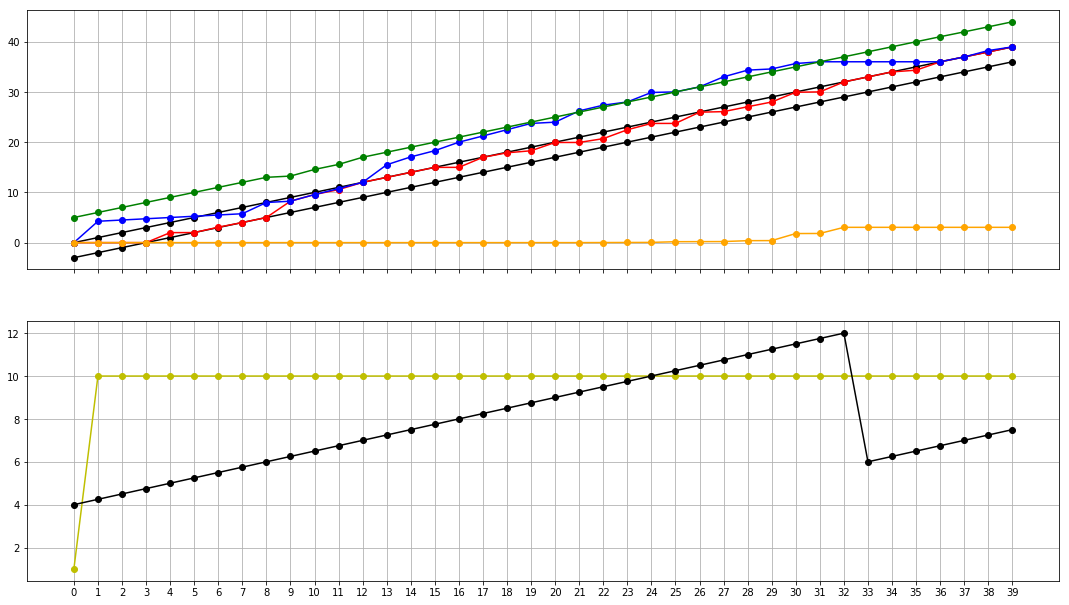

[ 0.          4.25        4.5         4.75        5.          5.25
  5.5         5.75        7.98611111  8.25        9.56944444 10.75
 12.         15.5        17.06944444 18.30555556 20.         21.23611111
 22.48611111 23.73611111 23.98611111 26.23611111 27.37114327 28.01388889
 29.90277778 30.01388889 31.01388889 33.01388889 34.3488391  34.58495021
 35.66666667 36.01388889 36.01388889 36.01388889 36.01388889 36.01388889
 36.01388889 36.97060534 38.24838312 38.97222222]
[ 0.          0.          0.          0.          1.98611111  2.
  3.06944444  4.          5.          8.25        9.56944444 10.55555556
 12.         12.98611111 13.98611111 14.98611111 14.98611111 16.98611111
 17.88503216 18.29166667 19.94444444 19.94444444 20.70833333 22.47222222
 23.73611111 23.73611111 25.97222222 26.08333333 27.05717243 28.
 29.94444444 30.01388889 32.         33.         34.         34.33495021
 36.         36.97060534 37.95671645 38.97222222]
[0.         0.         0.         0.         0.     

In [5]:
def convert(var):
    decimal = var.as_decimal(100)
    if decimal[-1] == '?':
        decimal = decimal[:-1]
    return float(decimal)

def plot(s):
    global lost
    m = s.model()
    outputs = [convert(m[o]) for o in out]
    inputs = [convert(m[i]) for i in inp]
    upper = [C * t + convert(m[Ku[t]]) for t in range(T)]
    lower = [C * t - convert(m[Kl[t]]) for t in range(T)]
    rates = [convert(m[r]) for r in rate]
    cwnds = [convert(m[w]) for w in cwnd]
    losts = [convert(m[l]) for l in lost]
    lthreshes = [convert(m[l]) for l in lthresh]
    losses_detected = [m[l] for l in lost_detected]
    times = [t for t in range(T)]

    outputs = np.asarray(outputs)
    inputs = np.asarray(inputs)
    upper = np.asarray(upper)
    lower = np.asarray(lower)
    rates = np.asarray(rates)
    cwnds = np.asarray(cwnds)
    losts = np.asarray(losts)
    lthreshes = np.asarray(lthreshes)
    times = np.asarray(times)
    adj = 0 #[B * t for t in range(T)]

    # Configure the plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(18.5, 10.5)
    ax1.grid(True)
    ax2.grid(True)
    ax2.set_xticks(range(0, T))
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    ax1.plot(times, lower - adj, color='black', marker='o')
    ax1.plot(times, upper - adj, color='black', marker='o')
    ax1.plot(times, outputs - adj, color='red', marker='o')
    ax1.plot(times, inputs - adj, color='blue', marker='o')
    ax1.plot(times, lthreshes - adj, color='green', marker='o')
    ax1.plot(times, losts - adj, color='orange', marker='o')
    for (loss_time, pkt_lost) in enumerate(losses_detected):
        if is_true(pkt_lost > 0):
            ax1.axvline(x=loss_time)

    ax2.plot(times, rates, color='y', marker='o')
    ax2.plot(times, cwnds, color='black', marker='o')
    #ax2.plot(times[1:], inputs[1:] - inputs[:-1], color='blue', marker='o')
    #ax2.plot(times[1:], outputs[1:] - outputs[:-1], color='red', marker='o')
    #ax2.plot(times[1:], upper[1:] - upper[:-1], color='black', marker='o')
    plt.show()
    
    print(inputs)
    print(outputs)
    print(losts)

plot(s)